In [2]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import math
import random
import librosa

def cage_variations(filenames):
    max_time = 0
    audio = []
    for file in filenames:
        f, sr = librosa.load(file)
        audio.append(f)
        max_time += len(f)

    num_tracks = len(audio)
    sr = 44100
    max_tracks = num_tracks
    max_seconds = 5

    track_index = []
    track_length = []
    time_to_go = []

    track_choices = []
    track_active = []
    
    tracks_active = []

    for i in range(num_tracks):
        track_index.append(0)
        track_length.append(len(audio[i]))
        time_to_go.append(0)
        track_choices.append(i)
        track_active.append(False)
        # Experimental here
        tracks_active.append(list())

    time_choices = list(range(1,(max_seconds*4)+1,1)) 
    time_choices[:] = [x / 4.0 for x in time_choices] # quarter seconds

    out = []

    def track_done(i): # have all samples of selected found sound been used?
        return track_index[i] >= track_length[i]

    def all_done(): # has every sample of every found sound been used?
        for i in range(0,4):
            if not track_done(i):
                return False
        return True

    def num_currently_active(): # number of tracks currently contributing to final audio
        active = 0
        for X in track_active:
            if X:
                active += 1
        return active

    ### MAIN LOOP ###

    current_sample = 0
    while not all_done() and current_sample < max_time:

        if current_sample % (sr / 4.0) == 0:

            for i in range(0,len(time_to_go)):
                if time_to_go[i] > 0:
                    time_to_go[i] -= 0.25
                if time_to_go[i] <= 0:
                    track_active[i] = False

            if not num_currently_active() == num_tracks:

                # choose random amount of tracks k based on how many are already active
                k = random.randint(1, max_tracks - num_currently_active()) 

                if k == 0: # do it again if empty so there is less emptiness
                    k = random.randint(0, max_tracks - num_currently_active()) 

                # choose k tracks
                tracks_chosen = random.sample(track_choices, k)

                # choose length each selection will run for
                times_chosen  = random.sample(time_choices, k)

                for i in range(0,len(tracks_chosen)):
                    track_active[tracks_chosen[i]] = True
                    samples = round( times_chosen[i] * sr )
                    # Sean added:
                    for _ in range(samples):
                        tracks_active[tracks_chosen[i]].append(1)
                    for j in range(len(tracks_active)):
                        if tracks_chosen[i] != j:
                            for _ in range(samples):
                                tracks_active[j].append(0)
                    time_to_go[tracks_chosen[i]] = times_chosen[i]


        temp = [0,0]
        for i in tracks_chosen:

            if not track_done(i):

                temp += audio[i][track_index[i]]
                track_index[i] += 1

        out.append(temp)

        current_sample += 1
    
    out = out/np.max(out) # Normalize
    
    return out, sr, tracks_active

In [3]:
files = [
    "drums.aif",
    "flute.aif",
    "guitar.aif",
    "piano.wav",
    "trumpet.aif",
    "violin.wav"
]

In [4]:
out, fs, tracks_active = cage_variations(files)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


FileNotFoundError: ignored

In [ ]:
def plot_the_data(data,fs):
    num_tracks = len(data)
    num_samples = len(data[1])
    plt.figure()
    plt.ylabel("Song number")
    plt.ylim( 0.5,num_tracks+0.5 ) # Give some buffer space on either side
    plt.xlabel("Time (s)")
    
    time_axis = np.linspace( 0,num_samples/fs,num_samples )
    for i in range(1,num_tracks+1):
        buffer = np.multiply( data[i-1],i ) # Zeroes won't scale, everything else will
        plt.scatter( time_axis,buffer,3 )

    plt.show()

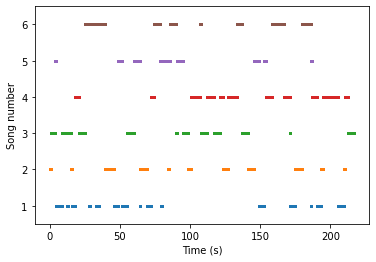

In [ ]:
plot_the_data(tracks_active,fs)

In [ ]:
sf.write("variations1.wav",out,samplerate=fs)